# XGBoost算法用于股价预测之性能测评 

In [ ]:
作者：dr.edwin@topfintel.com
平台：python 3 + jupyter notebook 

In [32]:
from stockpriceanna.pricegen import spgen #pip install stockpriceanna
import numpy as np
import pandas as pd
from xgboost import XGBRegressor 
from pylab import rcParams
from itertools import product
from pandas_datareader import data
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
current_date=pd.Timestamp("2019-07-15") 

一点点金融背景：

关于未来股票价格预测，各门各派都有自己的一套哲学，例如，曾经有美国猪手认为女生流行的裙子的长度也可以预测未来股票价格。技术分析学派专注于采用历史市场量价信息预测股价，而基础分析学派则相信基本面信息。本文以最简单的价格预模型为例，仅以历史价格未作预测特性，即：

$P_{t}$ = F([$P_{t-1}$,$P_{t-2}$.....$P_{t-k}$]) 

这里 $P_{t}$ 为股票在t日观察到的交易价，函数F为未知，XGBoost算法可用于数值计算F的取值。如其他机械学习算法，XGBoost算法不要求对F做出任何参数、形态假设。小编观察到市面上一些采用机器学习方法预测股价的文章直接将原始价格作为分析对象，这点小编认为并不明智。因为股价本身是一种无边界刻度，而XGBoost是以“种树”术为核心算法的，这种算法对于学习数组范围以外的预测都是傻乎乎的。所以，小编认为应该绕个弯，将价格转化为收益率。然后再针对收益率进行分析。以下是为实现这个方法而构造的一个小小的封包程序：

In [33]:
# 数据整理和分析程序

In [34]:
class XGBreg():
    def __init__(self,base_score=0.5, booster='gbtree', colsample_bylevel=1.0,colsample_bytree=1.0, gamma=0, importance_type='gain',
                   learning_rate=0.1, max_delta_step=0, max_depth=3,min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                   nthread=None, random_state=0, reg_alpha=0,reg_lambda=1, scale_pos_weight=1, seed=100, silent=True,
                   subsample=1.0,use_log=True,use_level=True,lag_order=1,objective="reg:squarederror",name=None,y_att="price"):
        #model parameters that will not be tuned, be aware that objective = "reg:squarederror" is only available after xgboost 9.0, before that they use "reg:linear"
        self.other_setting={"base_score":base_score,"booster":booster,"importance_type":importance_type,"max_delta_step":max_delta_step,
                            "missing":missing,"n_jobs":n_jobs,"nthread":nthread,"random_state":random_state,"reg_alpha":reg_alpha,
                            "reg_lambda":reg_lambda,"scale_pos_weight":scale_pos_weight,"seed":seed,"objective":objective}
        
        #model parameters that will be tuned for performance
        self.set_param = {"n_estimators":n_estimators,"max_depth":max_depth,"learning_rate":learning_rate,
                          "min_child_weight":min_child_weight,"subsample":subsample,"gamma":gamma,"colsample_bytree":colsample_bytree,"colsample_bylevel":colsample_bylevel}
        self.reset(self.set_param,lag_order=lag_order)  
        if name is None:
            self.name="unnamed"
        else:
            self.name = name
        self.use_log=use_log
        self.use_level = use_level
        self.y_att=y_att
    
    def __set_param(self,**arg):
        for _ in arg.keys():
            if _ in self.set_param.keys():
                self.set_param[_] = arg[_]
        
    def reset(self,new_param={},lag_order=None):  
        """
        set the XGB parameters and prepare for a new training assignment
        """
        #check for invalid inputs
        if "n_estimators" in new_param.keys():
            n_estimators = new_param["n_estimators"]
            if not (isinstance(n_estimators,int) and n_estimators>0):
                raise ValueError ("invalid n_estimators setting")
            else:
                self.__set_param(n_estimators=n_estimators)
        
        if "max_depth" in new_param.keys():
            max_depth = new_param["max_depth"]
            if not (isinstance(max_depth,int) and max_depth>0):
                raise ValueError ("invalid max_depth setting")
            else:
                self.__set_param(max_depth=max_depth)
        
        if "learning_rate" in new_param.keys():
            learning_rate = new_param["learning_rate"]
            if not (isinstance(learning_rate,float) and learning_rate>0 and learning_rate<1):
                raise ValueError ("invalid learning_rate setting")
            else:
                self.__set_param(learning_rate=learning_rate)
        
        if "min_child_weight" in new_param.keys():
            min_child_weight = new_param["min_child_weight"]
            if not (isinstance(min_child_weight,int) and min_child_weight>0):
                raise ValueError ("invalid min_child_weight setting")
            else:
                self.__set_param(min_child_weight=min_child_weight)

        if "subsample" in new_param.keys():
            subsample = new_param["subsample"]
            if not (isinstance(subsample,(int,float)) and subsample>0 and subsample<=1):
                raise ValueError ("invalid subsample setting")
            else:
                self.__set_param(subsample=subsample)

        if "gamma" in new_param.keys():
            gamma = new_param["gamma"]
            if not (isinstance(gamma,(float,int)) and gamma>=0):
                raise ValueError ("invalid gamma setting")
            else:
                self.__set_param(gamma=gamma)

        if "colsample_bytree" in new_param.keys():
            colsample_bytree = new_param["colsample_bytree"]
            if not (isinstance(colsample_bytree,(float,int)) and colsample_bytree>0 and colsample_bytree<=1):
                raise ValueError ("invalid colsample_bytree setting")
            else:
                self.__set_param(colsample_bytree=colsample_bytree)                

        if "colsample_bylevel" in new_param.keys():
            colsample_bylevel = new_param["colsample_bylevel"]
            if not (isinstance(colsample_bylevel,(float,int)) and colsample_bylevel>0 and colsample_bylevel<=1):
                raise ValueError ("invalid colsample_bylevel setting")    
            else:
                self.__set_param(colsample_bylevel=colsample_bylevel) 
                
        if lag_order is not None:
            self.lag_order = lag_order
        self.model=XGBRegressor(**{**self.set_param,**self.other_setting})
        #https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
        self.data = None #place holder

    def data_cleaner(self,data,next_date=None):
        """
        take a raw price series or a data set as input, return the responding time-indexed x data set, which contains all the lagged variables. 
        The time stamp for the one-step forward trade date is not unknown from the raw data set and thus it is either provided in the next_date argument or it will be estimated

        """
        y_att = self.y_att
        if isinstance(data,pd.Series):
            price_series = data
        else:
            if y_att not in data.columns:
                raise ValueError ("the y variable %s is not found in the dataset"%(y_att))
            price_series = data[y_att]
        if next_date is None:
            est_gap = data.index[-1]-data.index[-2] #the date of one-step prediction is being estimated here
            new_index=data.index[1:].append(pd.DatetimeIndex([data.index[-1]+est_gap])) 
        else:
            new_index=data.index[1:].append(pd.DatetimeIndex([next_date])) #the raw index is converged here to a data table. each observation of "y-price" is matched with its predictors
        new_x = pd.DataFrame(index=new_index)
        if self.use_log:
            new_x["P_lag1"] = np.log(price_series).values #log-price is being stored here if log-return is chosen 
            new_x["R_lag1"] = (new_x["P_lag1"] - new_x["P_lag1"].shift(1))
        else:
            new_x["P_lag1"] = price_series.values
            new_x["R_lag1"] = (new_x["P_lag1"] - new_x["P_lag1"].shift(1))/new_x["P_lag1"].shift(1)
        
        if isinstance(data,pd.DataFrame) and data.shape[1]>1: #for additional predictors 
            for att in set(data.columns)-set([y_att]):
                new_x["%s_lag1"%(att)] = data[att].values
            
        if self.lag_order>1:
            for i in range(2,self.lag_order+1):
                new_x["P_lag%s"%(i)] = new_x["P_lag1"].shift(i-1).values
                new_x["R_lag%s"%(i)] = new_x["R_lag1"].shift(i-1).values
                if isinstance(data,pd.DataFrame) and data.shape[1]>1:
                    for att in set(data.columns)-set([y_att]):
                        new_x["%s_lag%s"%(att,i)] = new_x["%s_lag1"%(att)].shift(i-1).values
        return new_x.dropna()
        
    def train(self,data,eval_size=None,early_stopping_rounds=None,decay_weight=None): 
        """
        weight_decay allows time decreasing weight assigned to pass observations
        eval_size and early_stopping_rounds setting allows early stopping
        """
        if not isinstance(data.index,pd.DatetimeIndex):
            raise ValueError ("need a time index pd.Series or pd.DataFrame as data input")
        else:
            self.data = data #keeping the training set here
        self.train_x = self.data_cleaner(data).iloc[:-1] #the last obs is not used in training because the one-step forward future price is not known
        if not self.use_level:
            train_x = self.train_x.drop(["P_lag%s"%(i) for i in range(1,self.lag_order+1)],axis=1)
        else:
            train_x = self.train_x
        if isinstance(data,pd.Series):
            y_data = data.astype(float)
        if isinstance(data,pd.DataFrame):
            y_data = data[self.y_att].astype(float)
        if self.use_log:
            self.train_y = (np.log(y_data)-np.log(y_data.shift(1))).reindex(self.train_x.index) #some observation in x are dropped due to the use of lag values
        else:
            self.train_y = (y_data/y_data.shift(1) -1).reindex(self.train_x.index)
        if decay_weight is not None:
            if decay_weight!=1:
                weight = [decay_weight**(self.train_y.size-i) for i in range(self.train_y.size)]
            else:
                weight = None
        else:
            weight = None
        if eval_size is None:
            self.model.fit(X=train_x, y=self.train_y,eval_metric="rmse",sample_weight=weight) 
        else:
            self.model.fit(X=train_x.iloc[:-eval_size], y=self.train_y[:-eval_size],
                           eval_set=[(self.train_x.iloc[-eval_size:],self.train_y[-eval_size:])],eval_metric="rmse",verbose=False,sample_weight=weight)
    
    def predict(self,prediction_step=1,new_x=None):
        """
        prediction_step=0 return the est values of the training_set
        prediction_step=1 return the one-step prediction outsite the training_set
        when new_x is provided, this method return the est values of the date in the new_x plus a one-step prediction.
        new_x must include price level data
        """
        if new_x is not None:    
            if not isinstance(new_x.index,pd.DatetimeIndex):
                raise ValueError ("require pd.Series type with pd.DatetimeIndex")
            if new_x.index[0]>self.data.index[-1]:
                temp_data = self.data.iloc[-(self.lag_order+1):].append(new_x) #plus 1 because return value need one more past observations
                new_x = self.data_cleaner(temp_data)
            else:
                raise ValueError ("new observations must be dated after the old ones")      
        else:
            if prediction_step==0:
                new_x = self.train_x
            elif prediction_step==1:
                temp_data = self.data.iloc[-(self.lag_order+1):]  #+1 becuase the return value need one more lag
                new_x = self.data_cleaner(temp_data).iloc[-1:]
            else:
                raise ValueError ("invalid prediction_step") 
        lag_y = new_x["P_lag1"]
        if not self.use_level:
            new_x = new_x.drop(["P_lag%s"%(i) for i in range(1,self.lag_order+1)],axis=1)
        est = self.model.predict(new_x)
        est = pd.Series(est,index=new_x.index)  #the index is in line with the realization of y
        if self.use_log:
            return np.exp(lag_y+est) 
        else:
            return lag_y *(1+est)

# 评分方法

In [35]:
def get_MAPE (est_price,realized_price,rd=5):
    """
    return the MAPE score and the benchmark score
    """
    return round((abs(est_price - realized_price)/realized_price).mean(),rd)

注意哦，本文采用百分比误差绝对值评定预测结果。

# 简单测试一下

linear trend(线性趋势) test:
In one-step prediction, XGBoost predicts预测 20.11204044694593, the correct answer正确答案 is 20.110000000000003
In multi-step forward prediction,XGBoost achieves absoluate percentage error(%) score of 0.00013
converging wave(收敛波) test:
In one-step prediction, XGBoost predicts预测 0.4565372702155707, the correct answer正确答案 is 0.4562066531295291
In multi-step forward prediction,XGBoost achieves absoluate percentage error(%) score of 0.00039

expanding wave(发散波)test:
In one-step prediction, XGBoost predicts预测 8.060022687666148, the correct answer正确答案 is 8.055151457804083
In multi-step forward prediction,XGBoost achieves absoluate percentage error(%) score of 0.00057

trending wave趋势波test:
In one-step prediction, XGBoost predicts预测 10.922929206426137, the correct answer正确答案 is 10.921980356450282
In multi-step forward prediction,XGBoost achieves absoluate percentage error(%) score of 5e-05


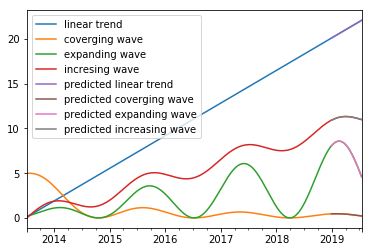

In [36]:
train_size=2000
test_size=200

test_func0 = lambda x: 0.1+0.01*x #linear trend
train_set0 = pd.Series([test_func0(i) for i in range(1,train_size+1)],index=pd.date_range(end=current_date.date()-pd.Timedelta(days=test_size),periods=train_size,freq="D"))
test_set0 = pd.Series([test_func0(i) for i in range(train_size,train_size+test_size)],index=pd.date_range(end=current_date.date(),periods=test_size,freq="D"))
x0 = XGBreg(name="linear trend")
x0.train(train_set0)
pred0 = x0.predict(prediction_step=1)[0]
preds0 = x0.predict(new_x=test_set0.dropna())
print ("linear trend(线性趋势) test:")
print ("In one-step prediction, XGBoost predicts预测 %s, the correct answer正确答案 is %s" %(pred0,test_func0(train_size+1)))
print ("In multi-step forward prediction,XGBoost achieves absoluate percentage error(%%) score of %s" %(get_MAPE(preds0,test_set0)))

test_func1 = lambda x: (5/(1+0.01*x))*(1+np.sin(x/100)) #coverging wave
train_set1 = pd.Series([test_func1(i) for i in range(1,train_size+1)],index=pd.date_range(end=current_date.date()-pd.Timedelta(days=test_size),periods=train_size,freq="D"))
test_set1 = pd.Series([test_func1(i) for i in range(train_size,train_size+test_size)],index=pd.date_range(end=current_date.date(),periods=test_size,freq="D"))
x1 = XGBreg(name="converging wave")
x1.train(train_set1)
pred1 = x1.predict(prediction_step=1)[0]
preds1 = x1.predict(new_x=test_set1.dropna())
print ("converging wave(收敛波) test:")
print ("In one-step prediction, XGBoost predicts预测 %s, the correct answer正确答案 is %s" %(pred1,test_func1(train_size+1)))
print ("In multi-step forward prediction,XGBoost achieves absoluate percentage error(%%) score of %s" %(get_MAPE(preds1,test_set1)))

test_func2 = lambda x: (1+0.01*x)*(1+np.sin(x/100))/5 #expanding wave
train_set2 = pd.Series([test_func2(i) for i in range(1,train_size+1)],index=pd.date_range(end=current_date.date()-pd.Timedelta(days=test_size),periods=train_size,freq="D"))
test_set2 = pd.Series([test_func2(i) for i in range(train_size,train_size+test_size)],index=pd.date_range(end=current_date.date(),periods=test_size,freq="D"))
x2 = XGBreg(name="expanding wave")
x2.train(train_set2)
pred2 = x2.predict(prediction_step=1)[0]
preds2 = x2.predict(new_x=test_set2.dropna())
print ("\nexpanding wave(发散波)test:")
print ("In one-step prediction, XGBoost predicts预测 %s, the correct answer正确答案 is %s" %(pred2,test_func2(train_size+1)))
print ("In multi-step forward prediction,XGBoost achieves absoluate percentage error(%%) score of %s" %(get_MAPE(preds2,test_set2)))

test_func3 = lambda x: 0.005*x+np.sin(x/100) #incresing wave
train_set3 = pd.Series([test_func3(i) for i in range(1,train_size+1)],index=pd.date_range(end=current_date.date()-pd.Timedelta(days=test_size),periods=train_size,freq="D"))
test_set3 = pd.Series([test_func3(i) for i in range(train_size,train_size+test_size)],index=pd.date_range(end=current_date.date(),periods=test_size,freq="D"))
x3 = XGBreg(name="expanding wave")
x3.train(train_set3)
pred3 = x3.predict(prediction_step=1)[0]
preds3 = x3.predict(new_x=test_set3.dropna())
print ("\ntrending wave趋势波test:")
print ("In one-step prediction, XGBoost predicts预测 %s, the correct answer正确答案 is %s" %(pred3,test_func3(train_size+1),))
print ("In multi-step forward prediction,XGBoost achieves absoluate percentage error(%%) score of %s" %(get_MAPE(preds3,test_set3)))

train_set0.append(test_set0).plot()
train_set1.append(test_set1).plot()
train_set2.append(test_set2).plot()
train_set3.append(test_set3).plot()
preds0.plot()
preds1.plot()
preds2.plot()
p0=preds3.plot()
p0.legend(['linear trend','coverging wave','expanding wave','incresing wave', 'predicted linear trend','predicted coverging wave', 'predicted expanding wave', 'predicted increasing wave'])

预测结果貌似不错，但这些价格序列有明显的套路，而实际价格走势包含众多的无法预估的坑坎（专治不服）。这些噪音据说是由流动性交易和非理性交易（大妈）造成的。下一步让我们看看XGB在这些噪音的影响下的预测能力。为了能够了解到价格序列中的噪音和基准成分，小编特意写了一个spgen小程序用于生成虚拟股票价格。下文将需要使用这个程序包，想了解具体操作的请查阅： https://github.com/edwincca/stockpriceanna/blob/master/README.md.

再多一点点背景

几何随机游走价格可由以下公式生成：

$P_{t}$ = $P_{t-1}$*exp($R_{t}$)

即 log$P_{t}$ = log$P_{t-1}$  + $R_{t}$ ，这里$R_{t}$为正态分布收益率代表新消息对股价的影响且与过往实现的收益率毫无关联。根据这个模型，在任何时刻对于将来股价的最理性预测就是目前的股价，下一期收益率最理性预测则为0。小编写的spgen可快速生成以几何随机游走模型为基础的虚拟价格序列，并且可在该基础上添加一些有趣的可预测性因子。spgen可生成的价格序列可概况为：

log$P_{t}$  = log$P_{t-1}$  + $R_{t}$ + $A_{t}$  + $N_{t}$ 

这里$A_{t}$对当期及以后的股价序列有永久影响，可视为可预测的价格因子，而 $N_{t}$ 只对当期股价有效果，因此可以视为噪音因子（不明白? 没关系，反正体育老师是这样教的）。



# 生成用于性能测试的虚拟价格序列

以下程序分别生成纯随机价格random walk（不可预测）及在此基础上衍生的带趋势 (fixed trend)、因对消息评估有偏差产生价格逆向(reversals)、动量趋势(momentum)行为、周期性（periodic）行为、以5日价格均线（5-day moving average)为支持的价格行为。

虚拟股价收益率统计


,mean,std,min,max,autocorr1,autocorr2,autocorr3
random walk,0.000271,0.010003,-0.031534,0.039586,-0.008633,0.010708,-0.019427
random walk + fixed trend,0.001271,0.010003,-0.030534,0.040586,-0.008633,0.010708,-0.019427
random walk + reversals,0.000271,0.017222,-0.059473,0.061740,-0.329085,0.012050,-0.024390
random walk + momentum,0.000746,0.013516,-0.055392,0.046596,0.651991,0.390923,0.174237
random walk + periodic moves,0.000271,0.015943,-0.069558,0.066034,-0.003302,0.013098,-0.020276
random walk + price level effect,0.000271,0.009847,-0.047851,0.033824,0.003769,0.049378,0.018710


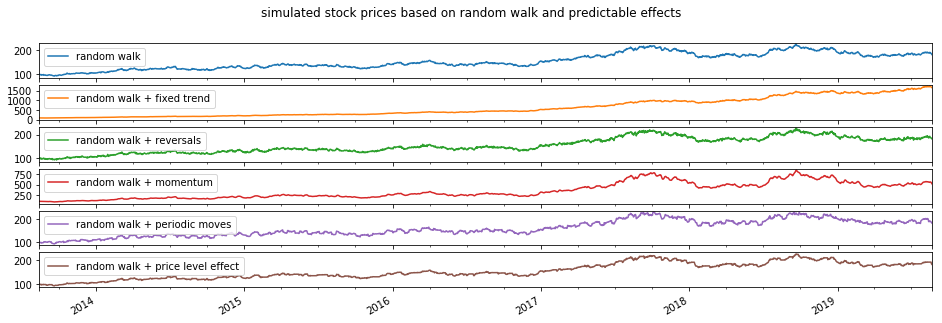

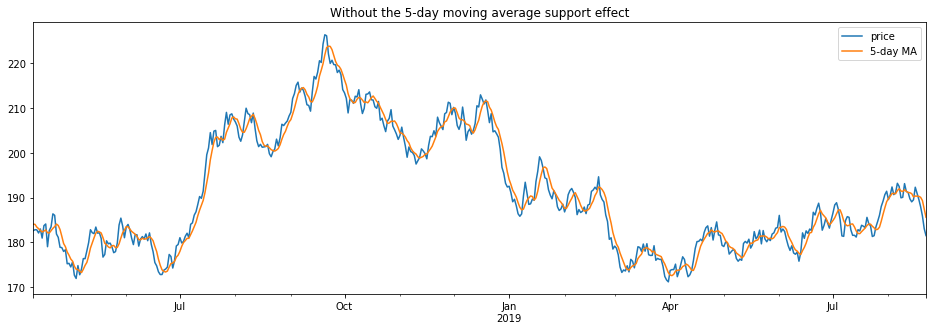

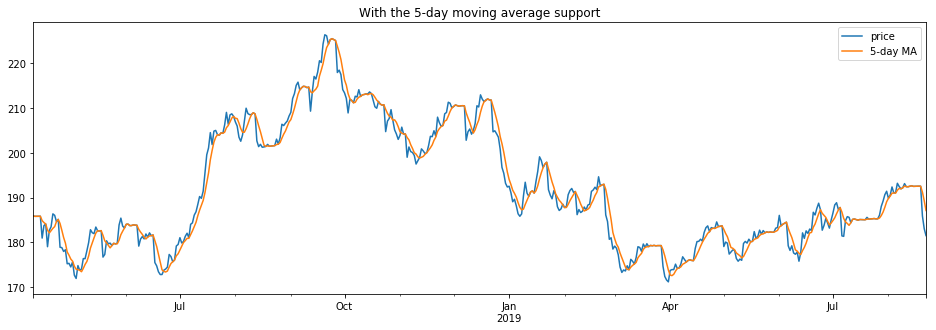

In [37]:
seed_factor=1
seed_noise=2
std = 0.01 #period-to-period std in returns.
trend_size=0.001
noise_std = 0.01
mom_size=0.7
pm_size=1.05

name_list = ['random walk', 'random walk + fixed trend','random walk + reversals', 'random walk + momentum','random walk + periodic moves','random walk + price level effect']
spgen_list=[spgen(size=train_size+test_size) for i in range(len(name_list))]
sp_list=[]

#a geometric random walk
spgen_list[0].gen_ln(mean=0,std=std,seed=seed_factor,name="factor")   
spgen_list[0].gen_price(method="m")
sp_list.append(spgen_list[0].show_price())

#a geometric random walk with a fixed trend
spgen_list[1].gen_ln(mean=0,std=std,seed=seed_factor,name="factor") 
spgen_list[1].gen_trend(rate=trend_size,name="trend")
spgen_list[1].gen_price(method="m")
sp_list.append(spgen_list[1].show_price())

#a geometric random walk with noise (reversals)
spgen_list[2].gen_ln(mean=0,std=std,seed=seed_factor,name="factor") 
spgen_list[2].gen_ln(mean=0,std=noise_std,seed=seed_noise,name="noise",add_type="noise")
spgen_list[2].gen_price(method="m")
sp_list.append(spgen_list[2].show_price())

#a geometric random walk with a positive autocorrelation in returns (momentum effect)
spgen_list[3].gen_ln(mean=0,std=std,seed=seed_factor,name="factor")
spgen_list[3].gen_ac(base="factor",rate=mom_size,lag=3,name="lag3_ac")
spgen_list[3].gen_price(method="m")
sp_list.append(spgen_list[3].show_price())

#a geometric random walk with periodic moves
spgen_list[4].gen_ln(mean=0,std=std,seed=seed_factor,name="factor")  
def pfunc (p,size=pm_size):
    if p ==0:
        return 1/size
    elif p == 11:  #seeing top and bottom in every 12-period window
        return  size
    else:
        return 1
spgen_list[4].gen_periodic(name="p12",func=pfunc,period=30)
spgen_list[4].gen_price(method="m")
sp_list.append(spgen_list[4].show_price())

#a geometric random walk with price support effect
spgen_list[5].gen_ln(mean=0,std=std,seed=seed_factor,name="factor")  
#a filter function for setting up the price effect - using the 5-day moving average as a support level
def MA5_filter(price,*args,**kargs):
    if price.size>5:
        temp_ma_lag = price.iloc[-6:-1].mean()
        temp_ma = price.iloc[-5:].mean()
        if price.iat[-2]>=temp_ma_lag and price.iat[-1]<temp_ma and price.iat[-1]>temp_ma*0.98:
            return price.iloc[-5:-1].mean()
        else:
            return price.iat[-1]
    else:
        return price.iat[-1]
spgen_list[5].gen_price(method="m",price_filter=MA5_filter)
sp_list.append(spgen_list[5].show_price())


#plot the price level data in 5 separate subplot
rcParams['figure.figsize'] = 16,5
pd.DataFrame(sp_list,index=name_list).T.plot(subplots=True,title="simulated stock prices based on random walk and predictable effects")
pd.DataFrame([sp_list[0],sp_list[0].rolling(5).mean()],index=["price","5-day MA"]).T.iloc[-500:].plot(title="Without the 5-day moving average support effect")
pd.DataFrame([sp_list[5],sp_list[5].rolling(5).mean()],index=["price","5-day MA"]).T.iloc[-500:].plot(title="With the 5-day moving average support")

#prepare the summary statistics for returns
spr_list=[np.log(sp_list[i])-np.log(sp_list[i].shift(1)) for i in range(len(name_list))]
report0=pd.DataFrame([spr_list[i].describe() for i in range(len(name_list))])[["mean","std","min","max"]]
report0.index=name_list
report0["autocorr1"] = [spr_list[i].autocorr(1) for i in range(len(name_list))]
report0["autocorr2"] = [spr_list[i].autocorr(2) for i in range(len(name_list))]
report0["autocorr3"] = [spr_list[i].autocorr(3) for i in range(len(name_list))]       
       
print ("虚拟股价收益率统计")
display(report0)


# 价格噪音下的XGBoost预测能力评分

In [38]:
score_saver0 = []
use_level=True
spgen_preds0=[]
for i in range(len(name_list)):
    xgb_temp=XGBreg(name=name_list[i],use_log=True,use_level=use_level)
    xgb_temp.train(sp_list[i].iloc[:train_size])
    temp_est=xgb_temp.predict(new_x=sp_list[i].iloc[train_size:train_size+test_size])
    spgen_preds0.append(temp_est)
    cv_score = get_MAPE(temp_est,sp_list[i].iloc[-test_size:])
    score_saver0.append(cv_score)
    ben_score = get_MAPE(sp_list[i].iloc[-(test_size+1):].shift(1).dropna(),sp_list[i].iloc[train_size:train_size+test_size])
    print ("%s: XGBoost MAPE score: %s, the benchmark score: %s" % 
           (name_list[i],
            cv_score,
            ben_score))
    

random walk: XGBoost MAPE score: 0.00769, the benchmark score: 0.00764
random walk + fixed trend: XGBoost MAPE score: 0.00801, the benchmark score: 0.00765
random walk + reversals: XGBoost MAPE score: 0.01276, the benchmark score: 0.01344
random walk + momentum: XGBoost MAPE score: 0.00804, the benchmark score: 0.01063
random walk + periodic moves: XGBoost MAPE score: 0.01003, the benchmark score: 0.00997
random walk + price level effect: XGBoost MAPE score: 0.0064, the benchmark score: 0.00591


评分结果显示，XGBoost算法在股价存在序列相关性时表现优于基准，但在其他情况下该算法未能超越基准。由此可见，在默认的参数设置下，XGBoost并不能识别股价的趋势、周期性行为、以及价格支持行为。之前已经提及，XGBoost对于学习区间范围以外的预测能力较弱，而当股价产生趋势行为的时，XGBoost常遇价格新高，因此会做出一些无厘头的预测。由于小编鸟事如神，一早就在编写数据包装程序加入了去除股价作为预测因子的设置，好奇的群众可将use_level设为False后，从新运行楼上的窗口，了解一下XGBoost对于分析趋势股价这一块，表现是否有所改进。

对于默认设置下，XGBoost对最后两类虚拟价格序列（periodic、price level effect）无能的情况是合理的。这类价格序列要求机器学习程序学会用n个周期的历史价格数据进行预测，例如5日均线则要求机器学习程序用预测日前5日的历史数据，虽然XGBoost有较强的预测因子筛选能力，但具体选择那些因子进入筛选池这是程序猿的工作。 最后，目前采用的验证方法是假设生成价格背后的超级模型和机制是静态的，但现实中应该是动态的。这就是说，如果价格模型是动态的，学习与验证数据组之间的距离越远，预测就约不靠谱。这种情况在周期性序列有所体验。例如程序通过学习了解到T+5是峰顶，但在验证中，随着时间迁移，峰顶的位置是会改变的，因此小编需要安排机器动态更新其预测模型的参数。

针对以上金融市场价格序列问题，小编认为需要做两个改进。第一，机器需要不断对新进入的价格数据进行学习更新模型并只对相邻周期的价格进行预测。第二，算法程序本身需要根据每个价格序列的特性，优化其保守性参数，以免被价格噪音带节奏。 

以下是针对以上问题，新加入的优化和测试程序。

In [39]:
# 动态预测验证方法

In [40]:
def tv(data,train_size,xgb,slient=False,return_MAPE=True,eval_size=None,early_stopping_rounds=None,y_att="price",decay_weight=None):
    """  
    Short for time-validation,this method perform validation by using the rolling-window approach.
    test_size = data size - train size. each prediction in the test set is based on the immediately preceeding training window
    eval_size an earily_stopping_rounds will passed to the API for early stopping
    on-line learning compacity can be added to this method but may not be useful for a tree-based learning algorithem.
    """
    if not slient:
        print ("performing rolling-window validation on %s" %(xgb.name))
        rt = None #place holder
        last_report=None
    if isinstance(data,pd.Series):
        realized_price = data.copy()
    else:
        realized_price = data[xgb.y_att].copy()
    realized_price.name = "realized_price"
    result = pd.DataFrame(realized_price).iloc[train_size:]
    result["est_price"] = np.NaN
    start_time = pd.datetime.today()
    for i in range(train_size,data.shape[0]):
        if not slient:
            temp_t = pd.datetime.today()
        train_data = data.iloc[i-train_size:i]
        xgb.train(train_data,eval_size=eval_size,early_stopping_rounds=early_stopping_rounds,decay_weight=decay_weight)
        result.at[data.index[i],"est_price"] = xgb.predict(prediction_step=1)[0]
        if not slient:
            lt = pd.datetime.today() - temp_t
            new_rt = ((data.shape[0] - i -1 )*lt).seconds
            if rt is None:
                print ("estimated time to finish %s seconds" %(new_rt))
                rt = max([new_rt,1])
            else:
                if last_report is None:
                    last_report = int(100*(new_rt/rt))
                else:
                    if last_report > (int(100*(new_rt/rt))+20):
                        print ("progress percentage %s%%" % (int(100*(1-new_rt/rt))))
                        last_report = int(100*(new_rt/rt))
    if not slient:
        print ("completed in %s seconds" % ((pd.datetime.today()-start_time).seconds))
    result = result.dropna()
    if return_MAPE:
        MAPE = get_MAPE(result["est_price"],result["realized_price"])
        benchmark_MAPE = get_MAPE(realized_price.shift(1),result["realized_price"])
        return [result,MAPE,benchmark_MAPE]
    else:
        return result

# 用虚拟价格数据测试动态预测验证方法

In [41]:
booster = "gbtree"
n_jobs=4  #adjust this setting for your computer's CPU. This block can take a few minutes to finish.
slient=False
use_level=True
XGB_list1=[XGBreg(name=name,booster=booster,use_log=True,use_level=use_level,n_jobs=n_jobs) for name in name_list]
vs_list1=[tv(data=sp_list[i],train_size=train_size,slient=slient,xgb=XGB_list1[i]) for i in range(len(name_list))]
tv_score = [vs_list1[i][1] for i in range(len(name_list))]
tv_benscore = [vs_list1[i][2] for i in range(len(name_list))]
report1 = pd.DataFrame([tv_score,score_saver0,tv_benscore],columns=report0.index,index=["tv_est动态检测","cv_est静态检测","benchmark_est基准"]).T
display(report1)

performing rolling-window validation on random walk
estimated time to finish 42 seconds
progress percentage 21%
progress percentage 66%
progress percentage 88%
completed in 44 seconds
performing rolling-window validation on random walk + fixed trend
estimated time to finish 43 seconds
progress percentage 18%
progress percentage 44%
progress percentage 72%
progress percentage 93%
completed in 27 seconds
performing rolling-window validation on random walk + reversals
estimated time to finish 11 seconds
progress percentage 27%
progress percentage 54%
progress percentage 81%
completed in 13 seconds
performing rolling-window validation on random walk + momentum
estimated time to finish 14 seconds
progress percentage 28%
progress percentage 50%
progress percentage 71%
progress percentage 92%
completed in 13 seconds
performing rolling-window validation on random walk + periodic moves
estimated time to finish 11 seconds
progress percentage -9%
progress percentage 18%
progress percentage 45%
pr

,tv_est动态检测,cv_est静态检测,benchmark_est基准
random walk,0.00767,0.00769,0.00764
random walk + fixed trend,0.00821,0.00801,0.00765
random walk + reversals,0.01257,0.01276,0.01344
random walk + momentum,0.00811,0.00804,0.01063
random walk + periodic moves,0.00996,0.01003,0.00997
random walk + price level effect,0.00640,0.00640,0.00591


# XGBoost参数优化程序

In [42]:
def tuning(data,xgb,parameter_range,cv_rate=0.1,slient=False):
    """
    This method finds the best parameter that has the highest t-validation score
    The search domain is provided through parameter_ranage - a dict type argument containing the possible values for each parameter
    cv_rate determines the size of test set in each t-validation run. 
    
    """
    train_size = int(data.shape[0]*(1-cv_rate))
    best_param = xgb.set_param.copy()
    if not slient:
        print ("In %s, calculating the basic score using the default parameter set %s" %(xgb.name,best_param))
    xgb.reset()
    best_score= tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
    if not slient:
        print ("completed, basic score: %s" %(best_score))
        print ("In %s, finding the best lag order from %s" %(xgb.name,parameter_range["lag_order"]))
    best_lo = xgb.lag_order #lag_order need to be added back to the param set here because it was not designed as a part of the XGB's parameter set.
    for lo in parameter_range["lag_order"]:#find best lag
        xgb.reset(lag_order=lo)
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score: #the smaller the better
            best_score  = temp_score
            best_lo = lo
    if not slient:
        print ("done - best lag order %s,current best score %s "%(best_lo,best_score))
        print ("In %s, finding the best n_estimators and max_depth_range from %s" %(xgb.name,[parameter_range["n_estimators"],parameter_range["max_depth"]]))
    for n_est,md in product(parameter_range["n_estimators"],parameter_range["max_depth"]):
        xgb.reset(lag_order=best_lo,new_param={"n_estimators":n_est,"max_depth":md})
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score:
            best_score  = temp_score
            best_param["n_estimators"] = n_est
            best_param["max_depth"] = md
    if not slient:
        print ("done, best n_estimators and max_depth: %s,current best score %s" %([best_param["n_estimators"],best_param["max_depth"]],best_score))
        print ("In %s, finding the best learning_rate and min_child_weight from %s" %(xgb.name,[parameter_range["learning_rate"],parameter_range["min_child_weight"]]))
    
    for lr,mcw in product(parameter_range["learning_rate"],parameter_range["min_child_weight"]):
        temp_param = best_param.copy()
        temp_param["learning_rate"]=lr
        temp_param["min_child_weight"]=mcw
        xgb.reset(lag_order=best_lo,new_param=temp_param)
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score:
            best_score  = temp_score
            best_param["learning_rate"] = lr
            best_param["min_child_weight"] = mcw
    if not slient:
        print ("done, best learning_rate and min_child_weight: %s,current best score %s" %([best_param["learning_rate"],best_param["min_child_weight"]],best_score))
        print ("In %s, finding the best subsample and gamma from %s" %(xgb.name,[parameter_range["subsample"],parameter_range["gamma"]]))
    for sub,gamma in product(parameter_range["subsample"],parameter_range["gamma"]):
        temp_param = best_param.copy()
        temp_param["subsample"]=sub
        temp_param["gamma"]=gamma
        xgb.reset(lag_order=best_lo,new_param=temp_param)
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score:
            best_score  = temp_score 
            best_param["subsample"] = sub
            best_param["gamma"] = gamma
    if not slient:
        print ("done, best subsample and gamma: %s,current best score %s" %([best_param["subsample"],best_param["gamma"]],best_score))                      
        print ("In %s, finding the best colsample_bytree and colsample_bylevel from %s" %(xgb.name,[parameter_range["colsample_bytree"],parameter_range["colsample_bylevel"]]))
    for cbt,cbl in product(parameter_range["colsample_bytree"],parameter_range["colsample_bylevel"]):
        temp_param = best_param.copy()
        temp_param["colsample_bytree"]=cbt
        temp_param["colsample_bylevel"]=cbl        
        xgb.reset(lag_order=best_lo,new_param=temp_param)
        temp_score = tv(data=data,train_size=train_size,xgb=xgb,slient=True)[1]
        if best_score > temp_score:
            best_score  = temp_score   
            best_param["colsample_bytree"] = cbt
            best_param["colsample_bylevel"] = cbl
    if not slient:
        print ("done, best colsample_bytree and colsample_bylevel: %s,current best score %s" %([best_param["colsample_bytree"],best_param["colsample_bylevel"]],best_score))
    best_param["lag_order"] = best_lo
    return [best_param,best_score]

def run_test(data,xgb,train_size,cv_rate,parameter_range,reopti_size=None,detail_report=False):
    reopti_counter = 1 #use to count the round after each tuning
    overall_result = pd.DataFrame(columns=["est_price","realized_price"],index=data.index[train_size:])
    if isinstance(data,pd.Series):
        overall_result["realized_price"] = data
        realized_price = data
    else:
        overall_result["realized_price"] = data[xgb.y_att]
        realized_price = data[xgb.y_att]
    for i in range(train_size,data.shape[0]): #i is the position of the data.index
        if reopti_counter == reopti_size:
            opti_data = data.iloc[i-train_size-reopti_size+1:i-reopti_size+1]
            test_data = data.iloc[i-reopti_size+1:i+1]
            print ("In %s, performing parameter tuning on training period [%s,%s] for the best XGBoost parameters(cv_rate %s):" %(xgb.name,opti_data.index[0].strftime("%Y-%m-%d"),opti_data.index[-1].strftime("%Y-%m-%d"),cv_rate))
            best_param = tuning(data = opti_data,xgb=xgb,parameter_range=parameter_range,cv_rate=cv_rate,slient= (not detail_report))
            print ("done,best parameter set %s" %(best_param))
            print ("use the best parameters to perform rolling-window cv on the test set [%s,%s]"%(test_data.index[0].strftime("%Y-%m-%d"),test_data.index[-1].strftime("%Y-%m-%d")))
            bl = best_param[0].pop("lag_order")
            xgb.reset(lag_order=bl,new_param = best_param[0])
            temp_result = tv(data=data.iloc[i-train_size-reopti_size+1:i+1],train_size=train_size,xgb=xgb,slient=(not detail_report))
            print ("interval report: tuning score: %s, test score: %s, benchmark score (test period): %s" % (best_param[1],temp_result[1],temp_result[2]))
            overall_result["est_price"].update(temp_result[0]["est_price"])
            reopti_counter=1
        else:
            reopti_counter+=1
        if i == data.shape[0]-2 and reopti_counter != reopti_size:
            reopti_size = reopti_counter
    MAPE = get_MAPE(overall_result["est_price"],overall_result["realized_price"])
    benchmark_MAPE = get_MAPE(realized_price.shift(1),overall_result["realized_price"])
    print ("overall score %s (vs benchmark score %s)" %(MAPE,benchmark_MAPE))
    return [overall_result,MAPE,benchmark_MAPE]

# 引入XGBoost参数优化进行动态预测测试

In [43]:
n_jobs=4 #adjust this setting for your computer's CPU. This block can take more than an hour.
cv_rate=0.04 #cv_rate is the portion of sample that are used in validation in the training set for finding the best parameter set - high number require more computing time
use_level=True
booster = "gbtree"
parameter_range = {"lag_order":[2,10,30],"n_estimators":[200,400],"learning_rate":[0.15,0.2],
                   "subsample":[0.1,0.3,0.6],"gamma":[0.1,1],"max_depth":[1,3,5],"min_child_weight":[3,5,15],"colsample_bytree":[0.3,0.6,0.9],"colsample_bylevel":[0.3,0.6,0.9]}

XGB_list2=[XGBreg(name=name,booster=booster,n_jobs=n_jobs,use_level=use_level) for name in name_list]
rt_result = [run_test(data=sp_list[i],xgb=XGB_list2[i],train_size=train_size,cv_rate=cv_rate,parameter_range=parameter_range) for 
             i in range(len(name_list))]

In random walk, performing parameter tuning on training period [2013-08-14,2019-02-03] for the best XGBoost parameters(cv_rate 0.04):
done,best parameter set [{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'min_child_weight': 5, 'subsample': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 10}, 0.00864]
use the best parameters to perform rolling-window cv on the test set [2019-02-04,2019-08-22]
interval report: tuning score: 0.00864, test score: 0.00766, benchmark score (test period): 0.00764
overall score 0.00766 (vs benchmark score 0.00764)
In random walk + fixed trend, performing parameter tuning on training period [2013-08-14,2019-02-03] for the best XGBoost parameters(cv_rate 0.04):
done,best parameter set [{'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'min_child_weight': 1, 'subsample': 1.0, 'gamma': 0, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'lag_order': 30}, 0.0083]
use the best parameters to perform rollin

In [47]:
print ("Summary Report: 优化后动态预测分数统计")
report2 = pd.DataFrame([[rt_result[i][1] for i in range(len(name_list))],tv_score,score_saver0,tv_benscore],columns=report0.index,index=["Tunned TV优化动态","TV动态","CV静态","Benchmark基准"]).T
display(report2)

Summary Report: 优化后动态预测分数统计


,Tunned TV优化动态,TV动态,CV静态,Benchmark基准
random walk,0.00766,0.00767,0.00769,0.00764
random walk + fixed trend,0.00829,0.00821,0.00801,0.00765
random walk + reversals,0.01282,0.01257,0.01276,0.01344
random walk + momentum,0.00805,0.00811,0.00804,0.01063
random walk + periodic moves,0.00841,0.00996,0.01003,0.00997
random walk + price level effect,0.00590,0.00640,0.00640,0.00591


预测结果经过参数优化后得到了较大的提升。经过一轮优化后，机器貌似找到了能识别价格序列中可预测因子的参数设置（如上陈述，fixed trend的问题需要另外解决）。由于XGBoost本身不支持快速在线学习。小编也测试过网上流传的把学习后的过程模型数据存到磁盘然后读取的方法。由于“种树法”本身就不存在支持在线学习的基因（新的数据只能用于树顶的分支），所以一旦采用了动态验证和参数优化的方法，运算时间将大幅增加。小编设计的XGBreg类程序带n_jobs接口用于支持多线程计算的，家里有矿的可以换个多核高频CPU测试一下自己计算机的性能。 

# Predicting Real Stock Market Price

现在用真实的股票数据测试一下上文开发的优化动态预测程序。本文以最流行的上证指数作为价格分析对象。有兴趣的玩家可以尝试使用其他股票的历史数据进行作测试。本文的英文版以SP500指数为样板分析对象，过了四级就可以看。 

In [45]:
train_size=2000
test_size=150
data_SHSE= data.DataReader('000001.SS', 'yahoo',  "1999-01-01", "2019-01-01") #下载上证指数的API
SHSE_index_early = data_SHSE.iloc[:train_size+test_size]["Adj Close"]
SHSE_index_recent =  data_SHSE.iloc[-(train_size+test_size):]["Adj Close"]
SHSE_data_early = pd.DataFrame(SHSE_index_early).rename(columns={"Adj Close":"price"})
SHSE_data_recent = pd.DataFrame(SHSE_index_recent).rename(columns={"Adj Close":"price"})
SHSE_r_early = SHSE_index_early/SHSE_index_early.shift(1)-1
SHSE_r_recent = SHSE_index_recent/SHSE_index_recent.shift(1)-1
report3 =pd.DataFrame([SHSE_r_early,SHSE_r_recent],index=["SHSE_return_early","SHSE_return_recent"]).T
report3 = report3.describe().T[["mean","std","min","max"]]
report3["autocorr1(滞1自相关)"] = [SHSE_r_early.autocorr(1),SHSE_r_recent.autocorr(1)]
report3["autocorr2(滞2自相关)"] = [SHSE_r_early.autocorr(2),SHSE_r_recent.autocorr(2)]
report3["autocorr3(滞3自相关)"] = [SHSE_r_early.autocorr(3),SHSE_r_recent.autocorr(3)]   
print ("股票指数收益率统计1999-01-01至2019-01-01")
display (report3)

股票指数收益率统计1999-01-01至2019-01-01


,mean,std,min,max,autocorr1(滞1自相关),autocorr2(滞2自相关),autocorr3(滞3自相关)
SHSE_return_early,6.872500e-04,0.014201,-0.088406,0.098570,0.012563,-0.011893,0.03144
SHSE_return_recent,-6.697930e-07,0.013765,-0.084909,0.057635,0.036259,-0.034374,0.01664


小编将上证指数从1990年1月1日开始到2019年1月1日每日股价收益率数据分为两组（early前期 vs recent后期)。初步统计数据显示，上证指数在前期趋势向上，后期则弱向下，两个时期收益率并无明显自相关。单从统计数据观察，上证指数走势接近于随机游走。注意，小编设计的优化动态检验程序带周期性重校对设置，既在n个预测过后，程序将重新走一遍参数优化流程，并以最新最优参数进行预测和校验。 

In [48]:
reopti_size = 100 #this means that the program will run the parameter tuning precedure again after making 50 forecasts,decreasing this number increases computing time but may reduce error. 
n_jobs = 4 
cv_rate = test_size/train_size
parameter_range = {"lag_order":[2,10,30],"n_estimators":[200,400],"learning_rate":[0.15,0.2],
                   "subsample":[0.3,0.6,0.9],"gamma":[0.1,1],"max_depth":[1,3,5],"min_child_weight":[3,5,15],"colsample_bytree":[0.3,0.6,0.9],"colsample_bylevel":[0.3,0.6,0.9]}
XGB_SHSE_early = XGBreg(name="SHSE_early",n_jobs=4,use_log=True,use_level=True)
XGB_SHSE_recent = XGBreg(name="SHSE_recent",n_jobs=4,use_log=True,use_level=True)
rt_SHSE_early =run_test(data=SHSE_index_early,train_size=train_size,cv_rate=cv_rate,xgb=XGB_SHSE_early,parameter_range=parameter_range,detail_report=False,reopti_size=reopti_size)
rt_SHSE_recent =run_test(data=SHSE_index_recent,train_size=train_size,cv_rate=cv_rate,xgb=XGB_SHSE_recent,parameter_range=parameter_range,detail_report=False,reopti_size=reopti_size)

In SHSE_early, performing parameter tuning on training period [1999-01-01,2006-09-20] for the best XGBoost parameters(cv_rate 0.075):
done,best parameter set [{'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.1, 'min_child_weight': 1, 'subsample': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 1}, 0.00967]
use the best parameters to perform rolling-window cv on the test set [2006-09-21,2007-02-26]
interval report: tuning score: 0.00967, test score: 0.01387, benchmark score (test period): 0.01397
In SHSE_early, performing parameter tuning on training period [1999-05-21,2007-02-26] for the best XGBoost parameters(cv_rate 0.075):
done,best parameter set [{'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.2, 'min_child_weight': 3, 'subsample': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 10}, 0.01216]
use the best parameters to perform rolling-window cv on the test set [2007-02-27,2007-05-14]
interval re

In [49]:
print ("上证指预测数分数统计")
report4 =pd.DataFrame([[rt_SHSE_early[1],rt_SHSE_early[2]],[rt_SHSE_recent[1],rt_SHSE_recent[2]]],index=["SHSE_return_early","SHSE_return_recent"],columns=["动态优化MAPE分数","基准分数"])
display(report4)


上证指预测数分数统计


,动态优化MAPE分数,基准分数
SHSE_return_early,0.01420,0.01433
SHSE_return_recent,0.01069,0.01016


XGBoost所得分数与随机漫步预测所得分数相近，该结果表示XGBoost认为过往指数走势对将来指数走势并没有什么预测价值。小编认为这种结果符合金融学理论的预测，若过往价格这类公共信息能预测股市，码农都可成马云了。 

在实际分析中，我们更倾向引入更多的信息、技术因子对将来股价进行预测。XGBoost在多因子模型中以下优势：1. 种树算法能够自动筛除无用的预测因子;2.快；3. 能识别因子之间的互动效果。于是小编试把成交量作为第二预测因子加入到校验流程中。小编认为成交量能反应当前进入市场信息的质量，毕竟只有存在对信息理解的分歧才能促成交易。 

# 多因子预测

In [50]:
#download the VIX index data, and prepare the index and return data, here I use log price and log return
train_size=2000
test_size=150
data_SHSE["vol"] =  data_SHSE["Volume"]/data_SHSE["Volume"].rolling(60).mean() #调整刻度导致其在不同时期具备可比较性
#SHSE_index_vol_early = data_SHSE.iloc[:train_size+test_size][["Adj Close","vol"]].dropna().rename(columns={"Adj Close":"price"}) #Yahoo提供的成交量信息在早期存在数据丢失，故这里只做后期的测试
SHSE_index_vol_recent =  data_SHSE.iloc[-(train_size+test_size):][["Adj Close","vol"]].dropna().rename(columns={"Adj Close":"price"})

reopti_size = 100 
n_jobs = 4 
cv_rate = test_size/train_size
parameter_range = {"lag_order":[2,10,30],"n_estimators":[200,400],"learning_rate":[0.15,0.2],
                   "subsample":[0.3,0.6,0.9],"gamma":[0.1,1],"max_depth":[1,3,5],"min_child_weight":[3,5,15],"colsample_bytree":[0.3,0.6,0.9],"colsample_bylevel":[0.3,0.6,0.9]}
XGB_SHSE_vol_recent = XGBreg(name="SHSE_vol_recent",n_jobs=4,use_log=True,use_level=True)
rt_SHSE_vol_recent =run_test(data=SHSE_index_vol_recent,train_size=train_size,cv_rate=cv_rate,xgb=XGB_SHSE_vol_recent,parameter_range=parameter_range,detail_report=False,reopti_size=reopti_size)

In SHSE_vol_recent, performing parameter tuning on training period [2010-03-05,2018-05-24] for the best XGBoost parameters(cv_rate 0.075):
done,best parameter set [{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.15, 'min_child_weight': 5, 'subsample': 1.0, 'gamma': 0, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'lag_order': 10}, 0.00647]
use the best parameters to perform rolling-window cv on the test set [2018-05-25,2018-10-22]
interval report: tuning score: 0.00647, test score: 0.01111, benchmark score (test period): 0.01084
In SHSE_vol_recent, performing parameter tuning on training period [2010-07-29,2018-10-22] for the best XGBoost parameters(cv_rate 0.075):
done,best parameter set [{'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.15, 'min_child_weight': 3, 'subsample': 1.0, 'gamma': 0, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.6, 'lag_order': 30}, 0.00958]
use the best parameters to perform rolling-window cv on the test set [2018-10-23,2019-01-02]
in

In [51]:
print ("上证指预测数分数统计")
report5 = report4.append(pd.DataFrame([[rt_SHSE_vol_recent[1],rt_SHSE_vol_recent[2]]],index=["SHSE_return_recent多因子"],columns=report4.columns))
display(report5)

上证指预测数分数统计


,动态优化MAPE分数,基准分数
SHSE_return_early,0.01420,0.01433
SHSE_return_recent,0.01069,0.01016
SHSE_return_recent多因子,0.01035,0.01016


由结果可见，加入了成交量因子稍微提升了预测成绩，但进步太小而意义不大，且也无法超越随机漫步。正如上文所说，成交量也是公共信息，根据金融学基本知识，利用公共信息预测股价都是不大靠谱的迷信行为(别太迷恋某些量化模型)。小编相信一些RMB玩家手头上是有不小有价值的潜在预测因子信息的。本文展示一种简单、暴力、快速的机器学习技术，供大家参考以更有效地利用信息对股价进行预测。 